설정

In [3]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

***

큰 수의 법칙

그림 저장: law_of_large_numbers_plot


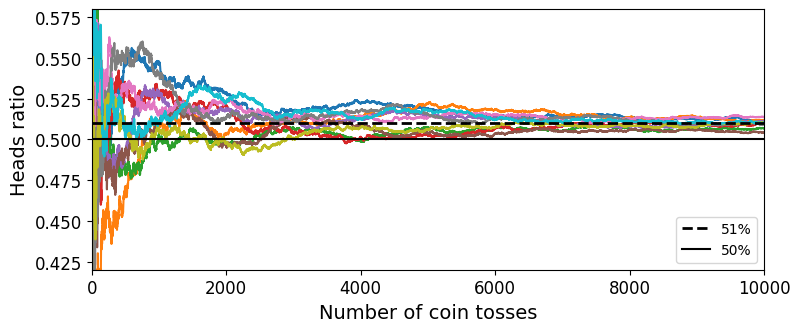

In [4]:
heads_proba = 0.51
# 행렬 크기 (10000, 10)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
# 행 따라서 누적, 10000행 10열
# 0 1 0 ... 1
# ...
# 5100 5099 ...

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

- 책에 나온 내용 재현

In [5]:
from scipy.stats import binom

print(1- binom.cdf(0, 1000, 0.51))     # 누적 확률 분포 1000번을 던졌을 때 51% 확률로 0번 이상 나올 확률
print(1- binom.cdf(1, 1000, 0.51))     # 누적 확률 분포 1000번을 던졌을 때 51% 확률로 1번 이상 나올 확률
print(1- binom.cdf(499, 1000, 0.51))     # 누적 확률 분포 1000번을 던졌을 때 51% 확률로 500번 이상 나올 확률
print(1- binom.cdf(4999, 10000, 0.51))     # 누적 확률 분포 10000번을 던졌을 때 51% 확률로 5000번 이상 나올 확률

1.0
1.0
0.7467502275563249
0.9777976478701107


***

투표 기반 분류기

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier           # 투표 기반 분류기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 향후 버전을 위해 사이킷런에서 기본 값이 될 solver="lbfgs", n_estimators=100, gamma="scale"로 지정
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')      # default 'hard'

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    # clf.score(...)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


In [8]:
for clf in voting_clf.estimators_ + [voting_clf]:      # 위랑 동일 코드
     print(clf.__class__.__name__, clf.score(X_test, y_test))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


간접 투표

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)     
# SVC 기본값에서 클래스 확률 제공 X predict_praba() 위해서 probability=True

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')      # 간접 투표  ... hard는 직접 투표 방식
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
# LogisticRegression 0.864
# RandomForestClassifier 0.896
# SVC 0.896
# VotingClassifier 0.92

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


***

배깅과 페이스팅

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
                                                        # 배깅
bag_clf = BaggingClassifier(                            # 회귀는 BaggingRegression
    DecisionTreeClassifier(), n_estimators=500,         # 결정 트리 분류기 500개 앙상블 훈련
    max_samples=100, bootstrap=True, random_state=42)   # 페이스팅은 bootstrap=False
# max_samples default 1.0 -> 중복 들어갈 수 있어서 원본이랑 동일하지는 X
# BaggingClassifier 특성 샘플링 지원 -> max_features, bootstrap_features로 조절

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)     # 결정 트리
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


- 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교

그림 저장: decision_tree_without_and_with_bagging_plot


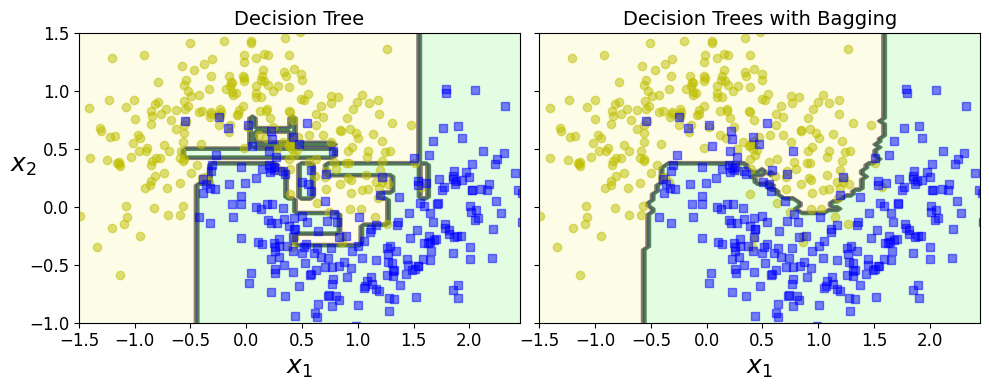

In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    # 2차원 평면의 포인트
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

- OOB 평가

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)    # oob 평가 ... 훈련 후 자동으로 평가 수행
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_                  # oob 평가 점수 결과

0.8986666666666666

In [15]:
bag_clf.oob_decision_function_     # oob 샘플에 대한 결정 함수의 값 oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)          # 정확도

0.912

***

랜덤 포레스트

In [17]:
from sklearn.ensemble import RandomForestClassifier
# bootstrap + 랜덤 특성 후보를 선택 ... sqrt(n_features)

# 랜덤 포레스트 - 분류
# 회귀는 RandomForestRegression
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
# 최대 16개의 leaf node를 갖는 500개 트리로 이루어진 랜덤 포레스트 분류기
# 일반적으로 max_samples를 훈련 세트의 크기로 지정
# cpu 다 쓰기 : n_jobs=-1
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

# 배깅 결정 트리 - 분류
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일합니다.

1.0

***

특성 중요도

In [18]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [19]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

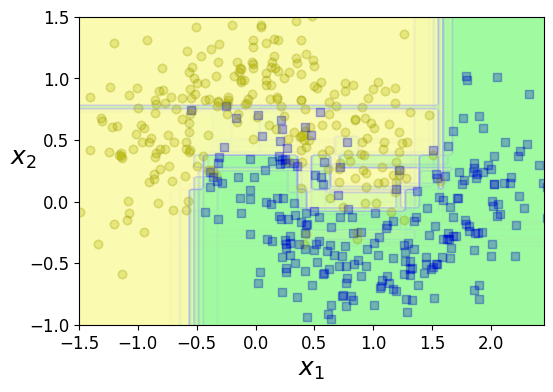

In [20]:
plt.figure(figsize=(6, 4))

# 15개 결정 트리의 결정 경계 중첩
for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

- 랜덤 포레스트로 15개 결정 경계 만들기

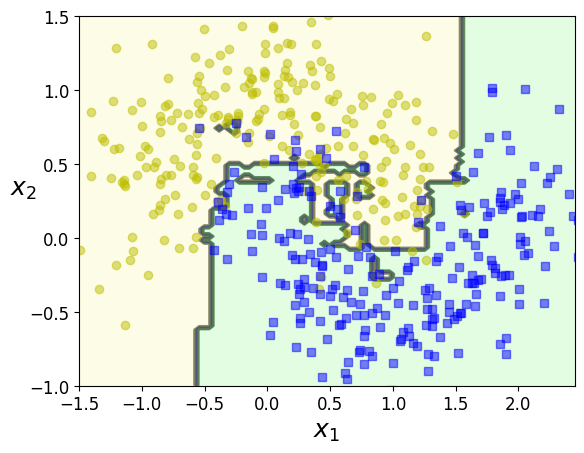

In [21]:
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X_train, y_train)

plot_decision_boundary(rf, X, y, axes=[-1.5, 2.45, -1, 1.5])
plt.show()

- MNIST 픽셀 중요도

In [22]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

c:\Python310\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


RandomForestClassifier(random_state=42)

그림 저장: mnist_feature_importance_plot


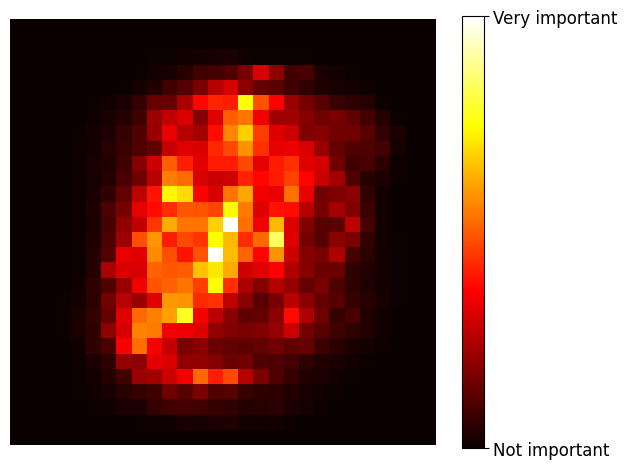

In [23]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

***

부스팅

- 에이다 부스트

In [24]:
from sklearn.ensemble import AdaBoostClassifier

# 200개의 얕은 결정 트리를 기반으로 하는 에이다 부스트 분류기 ... 기본 추정기
ada_clf = AdaBoostClassifier(                                   # 회귀는 AdaBoostRegressor
    DecisionTreeClassifier(max_depth=1), n_estimators=200,      # max_depth=1, 결정 노드 1, 리프 노드 2
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
# sklearn이 에이다 부스트의 다중 클래스 버전 SAMME 사용, 클래스 2개면 동일
# SAMME.R(Real) 알고리즘이 예측값 대신 클래스 확률에 기반

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

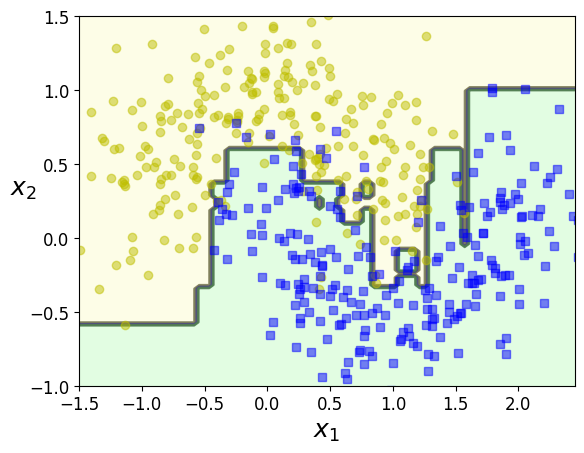

In [25]:
plot_decision_boundary(ada_clf, X, y)

그림 저장: boosting_plot


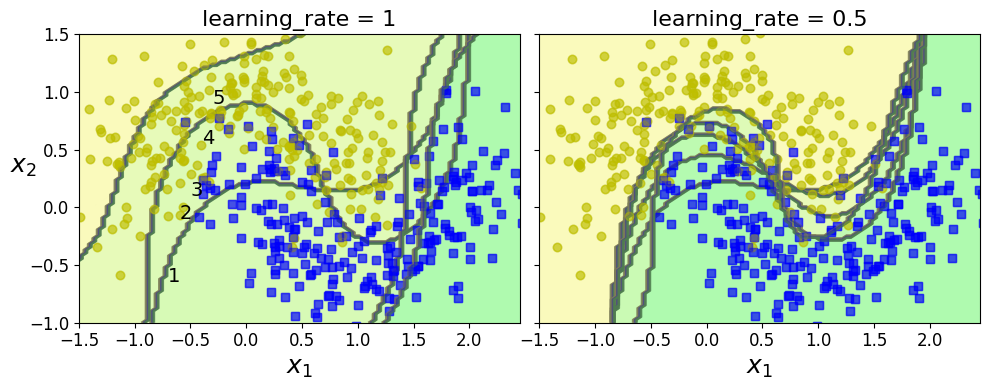

In [26]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [27]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

In [28]:
ada_clf.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

- 그레이디언트 부스팅

In [29]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)           # 1) 훈련 세트에 학습

DecisionTreeRegressor(max_depth=2, random_state=42)

In [30]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)          # 2) 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor 훈련

DecisionTreeRegressor(max_depth=2, random_state=42)

In [31]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)          # 3) 두 번째 예측기에서 생긴 잔여 오차에 세 번째 DecisionTreeRegressor 훈련

DecisionTreeRegressor(max_depth=2, random_state=42)

In [32]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
# 새로운 샘플에 대한 예측 생성 위해 모든 트리의 예측 더함
y_pred

array([0.75026781])

그림 저장: gradient_boosting_plot


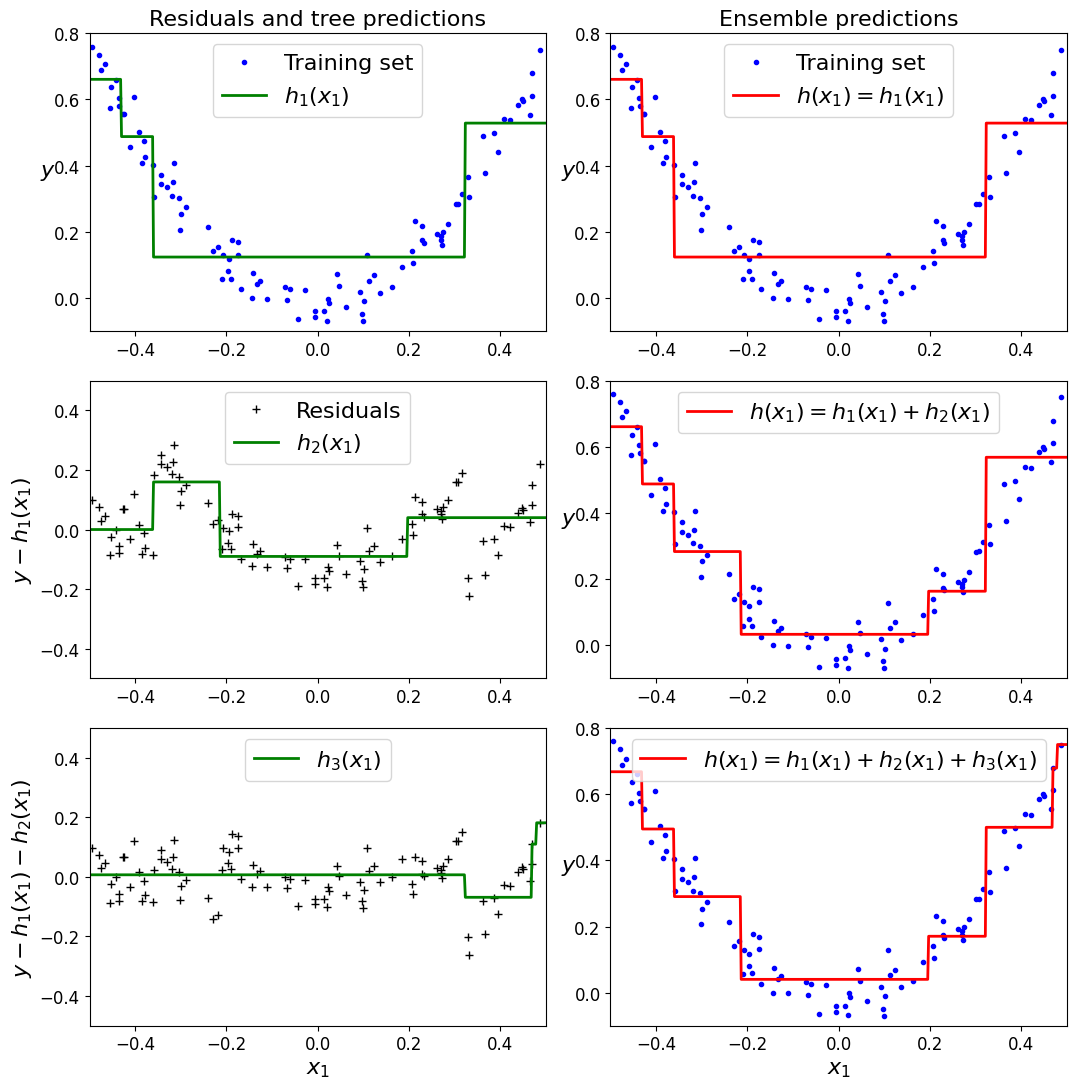

In [33]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
# DecisionTreeRegressor 사용 ... GradientBoostingClassifier도 동일
# target - pred (손실함수 미분)

# GRBT 앙상블 한 번에 훈련
# learning_rate가 각 트리의 기여 정도 조절
# loss 매개변수 default 'ls', GradientBoostingClassifier(loss='deviance) default
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

- 예측기가 너무 부족한 경우(트리 부족), 너무 많은 경우(트리 과다, 과대 적합)

In [35]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

그림 저장: gbrt_learning_rate_plot


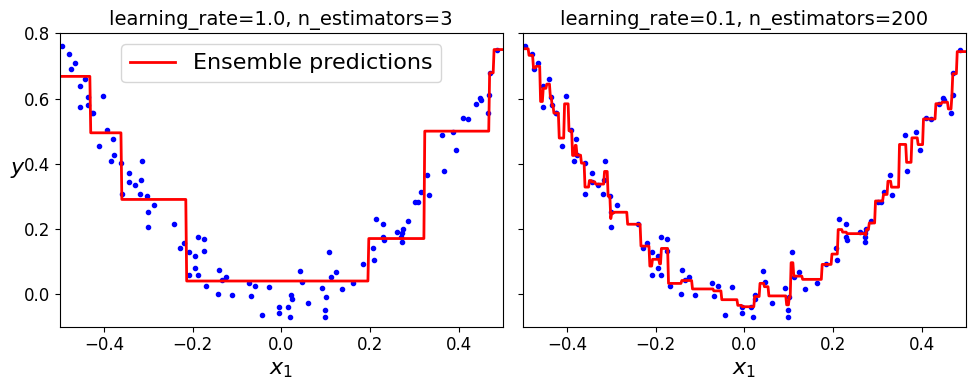

In [36]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

- 조기 종료로 최적의 트리 수 찾기

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

그림 저장: early_stopping_gbrt_plot


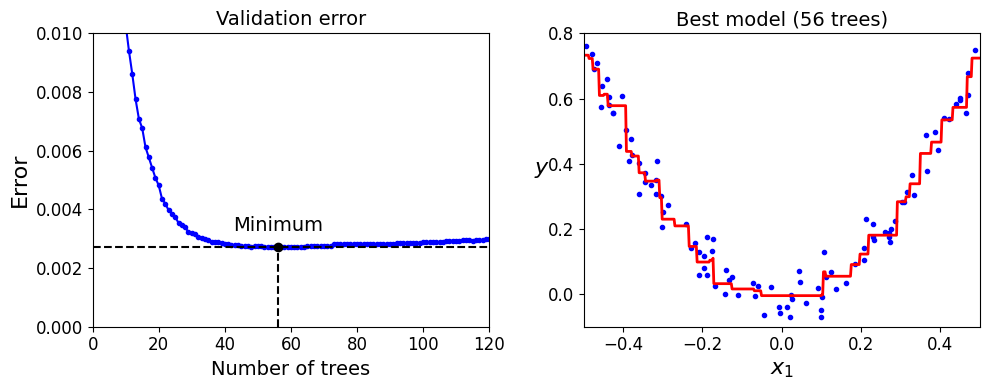

In [38]:
min_error = np.min(errors)

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

- 5 epoch 동안 향상되지 않을 때 훈련 중지

In [39]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42) # 기존 트리 유지, 혼련 추가
# 각 트리가 훈련할 때 사용할 훈련 샘플의 비율 지정 가능한 subsample 매개변수 사용 가능
# ex. subsample=0.25 -> 각 트리가 무작위로 선택된 25% 훈련 샘플로 학습 ... 편향 분산 반비례

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)    # 최적의 트리 개수

61


In [40]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


***

XGBoost 라이브러리 - 최적화된 그레이디언트 부스팅 구현

In [41]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [42]:
if xgboost is not None:  # 책에 없음
    xgb_reg = xgboost.XGBRegressor(random_state=42) # n_estimators=100, max_depth=3 default
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # 책에 없음
    print("Validation MSE:", val_error)           # 책에 없음

Validation MSE: 0.004000408205406276


In [43]:
if xgboost is not None:  # 책에 없음
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2) # 트리를 추가하는 반복 횟수
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # 책에 없음
    print("Validation MSE:", val_error)            # 책에 없음

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
Validation MSE: 0.002630868681577655


c:\Python310\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [44]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None     # 속도 측정

24.9 ms ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

50.9 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


- microsoft에서 제공하는 히스토그램 기반의 부스팅 라이브러리 lightgbm

In [46]:
from lightgbm import LGBMRegressor

lgb_reg = LGBMRegressor(random_state=42)
lgb_reg.fit(X_train, y_train)

y_pred = lgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
val_error

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1
[LightGBM] [Info] Start training from score 0.264976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

0.01777549654697777

In [47]:
%timeit LGBMRegressor().fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 75, number of used features: 1
[LightGBM] [Info] Start training from score 0.264976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [49]:
# sklearn 0.21v
# sklearn의 히스토그램 기반 부스팅 - 회귀
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_reg = HistGradientBoostingRegressor()
hgb_reg.fit(X_train, y_train)

y_pred = hgb_reg.predict(X_val)

c:\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [50]:
%timeit HistGradientBoostingRegressor().fit(X_train, y_train)

21.2 s ± 1.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


***

연습 문제 정답

8. 투표 기반 분류기
MNIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다(예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플).

In [48]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(max_iter=100, random_state=42, tol=20)


c:\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Training the MLPClassifier(random_state=42)


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
[estimator.score(X_val, y_val) for estimator in estimators]
# 선형 SVM이 성능 많이 떨어짐

[0.9692, 0.9715, 0.859, 0.9615]

In [ ]:
from sklearn.ensemble import VotingClassifier

named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

voting_clf = VotingClassifier(named_estimators)

voting_clf.fit(X_train, y_train)

c:\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(max_iter=100, random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)
# 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결

0.9704

In [ ]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9692, 0.9715, 0.859, 0.9615]

In [ ]:
voting_clf.set_params(svm_clf=None)          # SVM 모델 제거로 성능 향상 여부 확인

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', None),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [ ]:
voting_clf.estimators                        # 예측기 목록 업데이트 됨

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', None),
 ('mlp_clf', MLPClassifier(random_state=42))]

In [ ]:
voting_clf.estimators_                       # 훈련된 예측기 목록 업데이트 안됨

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [ ]:
del voting_clf.estimators_[2]

In [ ]:
voting_clf.score(X_val, y_val)               # 재평가

0.9737

In [ ]:
voting_clf.voting = "soft"
voting_clf.score(X_val, y_val)               # 간접 투표 분류기 사용

0.9688

In [ ]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)             # 직접 투표 분류기 사용, 테스트 세트로 확인

0.9701

In [ ]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_] 

[0.9645, 0.9691, 0.9593]

9. 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜 보세요.

In [ ]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 3., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [ ]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rnd_forest_blender.oob_score_

0.9704

- 스태킹 앙상블 평가

In [ ]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

y_pred = rnd_forest_blender.predict(X_test_predictions)

from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9661

***